# Flightpath characterization
In this notebook we look at the characterization of the flight path. Up until now we've just flown in a circle, parameterized by radius and speed. That's pretty boring for the optimization, so let's look at something more interesting.

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../source/Noise/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from NoiseBayes import NoiseBayes

from FOM_stationary import FOM_stationary as FOM
from OEDUtility import OEDUtility
from Drone import Drone as Drone

from DetectorPointwise import DetectorPointwise
from DetectorUniform import DetectorUniform
from DetectorGaussian import DetectorGaussian
from DetectorTruncGaussian import DetectorTruncGaussian

# specify which navigation class we are using
from NavigationSegment import NavigationSegment as Navigation

import time
tStart_notebook = time.time()

## User settings

In [2]:
centers = [[0.4, 0.6], [0.6, 0.4]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_steps = 500

sigma = 0.05  # std deviation for gaussian-type measurements. Get pointwise data for sigma -> 0
radius = 0.05  # truncation radius for truncation-style measurements

meshDim = 20  # discretization parameter (1D) for FOM
meshDim_drone = 10  # discretization parameter (1D) for subdomain in truncation-type measurements
polyDim = 3

n_test = 100 # resolution for 1D plots

## Setup

In [3]:
tStart = time.time()

# initialize full-order model
fom = FOM(meshDim = meshDim, centers=centers, polyDim=polyDim)
n_para = fom.n_para

# set a prior
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

# NavigationCircle was imported as Navigation
navigation = Navigation(grid_t = np.linspace(0, 1, n_steps))

# point-wise measurements
detector = DetectorPointwise(fom)

# initialize drone
drone = Drone(detector=detector, navigation=navigation, fom=fom)

# set noise model
noise = NoiseBayes(grid_t = drone.grid_t)
noise.parameterize_noise_model(c_scaling = 1e+3, c_diffusion = 1)
inversion = InverseProblem(fom, drone, noise=noise)

# initialize utility functions
utility = OEDUtility(inversion)

print("Runtime of this block: {} s".format(time.time()-tStart))

Runtime of this block: 0.3418459892272949 s


In [4]:
# compute one solution for nicer visualization below
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)

## Path characterization

In [56]:
alpha_middle = np.array([0.8, 0.4, 3, 0.5, 1])
# initial-x, initial-y, heading, velocity, angular-velocity

(-0.05, 1.05)

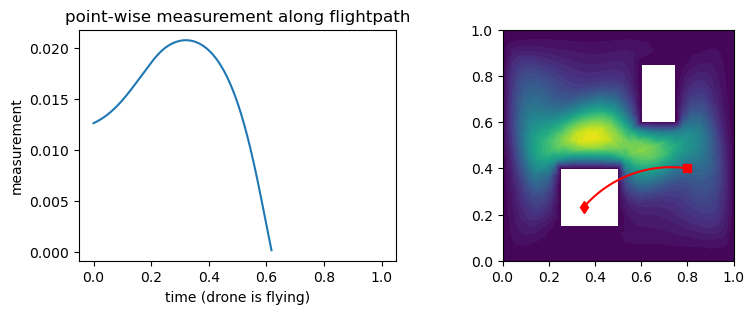

In [57]:
# compute flight
flight = drone.plan_flight(alpha=alpha_middle, grid_t=drone.grid_t)  # Flight object
flightpath, grid_t = flight.flightpath, flight.grid_t  # path and its time discretization

# measure data
data = drone.measure(flight=flight, state=state)

fig, axs = plt.subplots(1, 2, figsize = (9, 3))
fom.plot(state, ax=axs[0])
axs[1].plot(flightpath[:, 0], flightpath[:, 1], color="r")
axs[1].plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
axs[1].plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

axs[0].plot(grid_t, data)
axs[0].set_xlabel("time (drone is flying)")
axs[0].set_ylabel("measurement")
axs[0].set_title("point-wise measurement along flightpath")
axs[0].set_xlim(grid_t[0]-0.05, grid_t[-1]+0.05)

It is very, very important that we are not just treating missing measurements as zero. Remember that we are using a correlated noise model. Substituting missing measurements with zero is not the same as taking them out.

In [58]:
# compute posterior
posterior = inversion.compute_posterior(alpha=alpha_middle)
util_ref = [utility.eval_utility(posterior, mode="A"), utility.eval_utility(posterior, mode="D")]
d_util_ref = [utility.d_utility_d_control(posterior, mode="A"), utility.d_utility_d_control(posterior, mode="D")]

print("A-OED:", util_ref[0])
print("D-OED:", util_ref[1])
print("E-OED:", utility.eval_utility(posterior, mode="E"))

A-OED: 1.296956525566452
D-OED: 0.2975876831147734
E-OED: 0.9991011002989493


In [59]:
directions = np.zeros((n_test, 5))

directions[:, 0] = np.linspace(0, 1, n_test) # initial x position
directions[:, 1] = np.linspace(0, 1, n_test) # initial y position
directions[:, 2] = np.linspace(0, 2*np.pi, n_test) # initial heading (in radian)
directions[:, 3] = np.linspace(0, 2*alpha_middle[3], n_test) # velocity

yolo = np.max([5, 2*np.abs(alpha_middle[4])])
directions[:, 4] = np.linspace(-yolo, yolo, n_test) # angular velocity

utils = np.zeros((n_test, 5, 2))
for i in range(n_test):
    if not i % 10: 
        print("iteration {} / {}".format(i+1, n_test))
    
    for j in range(5):
        alpha = alpha_middle.copy()
        alpha[j] = directions[i, j]
        
        posterior = inversion.compute_posterior(alpha=alpha)
        utils[i,j,0] = utility.eval_utility(posterior, mode="A")
        utils[i,j,1] = utility.eval_utility(posterior, mode="D")



iteration 1 / 100
iteration 11 / 100
iteration 21 / 100
iteration 31 / 100
iteration 41 / 100
iteration 51 / 100
iteration 61 / 100
iteration 71 / 100
iteration 81 / 100
iteration 91 / 100


(-0.25, 2.25)

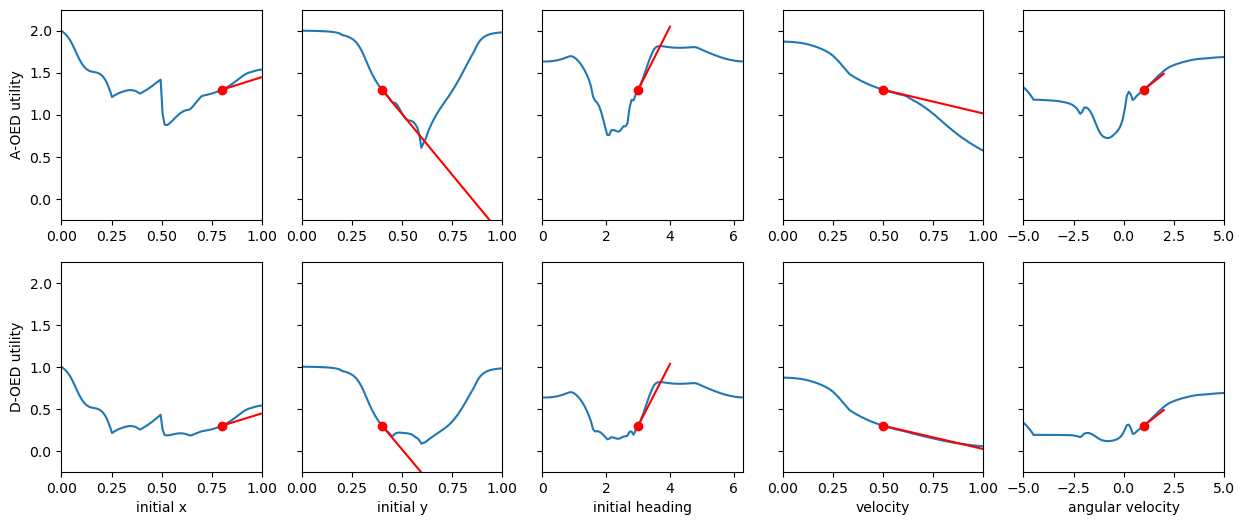

In [62]:
names_control = ["initial x", "initial y", "initial heading", "velocity", "angular velocity"]

fig, axs = plt.subplots(2, 5, figsize = (15, 6), sharey=True)

for j in range(5):
    for i in range(2):
        
        axs[i,j].plot(directions[:, j], utils[:, j, i])
        axs[i,j].plot(alpha_middle[j], util_ref[i], marker = "o", color = "r") # reference value
        axs[i,j].plot([alpha_middle[j], alpha_middle[j]+1], 
                      [util_ref[i], util_ref[i]+d_util_ref[i][j]], color="r") # reference derivative
        
        axs[i,j].set_xlim(directions[0,j], directions[-1, j])
        
        
    axs[1,j].set_xlabel(names_control[j])
    
axs[0, 0].set_ylabel("A-OED utility")
axs[1, 0].set_ylabel("D-OED utility")
axs[0, 0].set_ylim(-0.25, 2.25)

## Optimization

In [63]:
from Optimization.DAE import Objective as objective_class

In [67]:
problem_obj = objective_class(grid_t, utility, inversion, 
                              piecewise_constant=None,
                              use_exact_DAE = False,
                              circle_mode = False,
                              enforce_initial_position = False,
                              # enforce_initial_position = True,
                              enforce_final_position = False,
                              # enforce_final_position = True,
                              periodic = False,
                              reg_strength = 1e-5,
                              OED_utility_mode = "D",
                              # OED_utility_mode = "mix",
                              # OED_mix = {"A": 1e-2, "E": 1.0},
                              # v_lower = 0.1,
                              # v_upper = 3,
                              acc_lower = -np.inf,
                              acc_upper = np.inf,
                              # omega_upper = 100,
                              # omega_lower = -100,
                              omega_acc_upper = np.inf,
                              omega_acc_lower = -np.inf,
                              build_video = True,
                              x0 = flightpath[0,0],
                              y0 = flightpath[0,1],
                              x_final = flightpath[-1,0],
                              y_final = flightpath[-1,1],
                              # x0 = 0.1,
                              # y0 = 0.1,
                              # x_final = 0.7,
                              # y_final = 0.3,
                              obstacle_buffer = 0.0,
                              L = 3.0,
                             )

In [69]:
problem_obj.objective(alpha_middle)

0.2975876831147734

In [ ]:
problem_obj.add_option("hessian_approximation", "limited-memory")
problem_obj.add_option("tol", 1e-3)
# problem_obj.add_option("max_iter", 3)
# problem_obj.add_option("derivative_test_print_all", "yes")
# problem_obj.add_option("derivative_test", "first-order")
# problem_obj.add_option("gradient_approximation", "finite-difference-values")
# Solve the problem
solution, info = problem_obj.solve(x0)
# solution, info = problem.solve(solution)